In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the start and end rows and columns of a chunk product on the full disk grid for a channel
def load_channel_chunk_grid_parameters(product,channel):
    dataset = nc.Dataset(product,'r')
    
    start_row_index = dataset[f'data/{channel}/measured/start_position_row'][:] - 1
    end_row_index = dataset[f'data/{channel}/measured/end_position_row'][:] - 1
    start_column_index = dataset[f'data/{channel}/measured/start_position_column'][:] - 1
    end_column_index = dataset[f'data/{channel}/measured/end_position_column'][:] - 1
    channel_ssd = dataset[f'data/{channel}/ssd_index'][:]
    
    dataset.close()
    
    return start_row_index,end_row_index,start_column_index,end_column_index,channel_ssd

In [3]:
SSDS = ['0.5km', '1km', '2km']

# load the parameters configuring the geostationary projection-based grid
def load_grid_parameters(product):
    dataset = nc.Dataset(product,'r')
    
    grid_parameters = {}
    
    # ssd independent parameters
    mtg_geos_projection = dataset['data/mtg_geos_projection']
    grid_parameters['semi_major_axis']                = mtg_geos_projection.semi_major_axis
    grid_parameters['semi_minor_axis']                = mtg_geos_projection.semi_minor_axis
    grid_parameters['perspective_point_height']       = mtg_geos_projection.perspective_point_height
    grid_parameters['longitude_of_projection_origin'] = mtg_geos_projection.longitude_of_projection_origin
    
    # ssd dependent parameters
    reference_grids                          = dataset['state/processor/reference_grid'][:]
    reference_grid_number_of_rows            = dataset['state/processor/reference_grid_number_of_rows'][:]
    reference_grid_number_of_columns         = dataset['state/processor/reference_grid_number_of_columns'][:]
    reference_grid_spatial_sampling_angle_ns = dataset['state/processor/reference_grid_spatial_sampling_angle_ns'][:]
    reference_grid_spatial_sampling_angle_ew = dataset['state/processor/reference_grid_spatial_sampling_angle_ew'][:]
    
    for grid_index in range(len(reference_grids)):
        ssd_index = reference_grids[grid_index]
        ssd_index=0
        #print(ssd_index)
        ssd = SSDS[ssd_index]
        grid_parameters[ssd] = {}
        grid_parameters[ssd]['azimuth_grid_sampling']   = reference_grid_spatial_sampling_angle_ns[grid_index]
        grid_parameters[ssd]['elevation_grid_sampling'] = reference_grid_spatial_sampling_angle_ew[grid_index]
        grid_parameters[ssd]['azimuth0']   =   reference_grid_spatial_sampling_angle_ns[grid_index] * (reference_grid_number_of_rows[grid_index]    / 2 - 0.5)
        grid_parameters[ssd]['elevation0'] = - reference_grid_spatial_sampling_angle_ew[grid_index] * (reference_grid_number_of_columns[grid_index] / 2 - 0.5)
        grid_parameters[ssd]['reference_grid_number_of_rows']    = reference_grid_number_of_rows[grid_index]
        grid_parameters[ssd]['reference_grid_number_of_columns'] = reference_grid_number_of_columns[grid_index]
    
    dataset.close()
    
    return grid_parameters

In [4]:
def plot_data(data,title):
    plt.figure(figsize=(20,10))
    plt.tight_layout()
    plt.imshow(data)
    plt.title(title)
    plt.show()

In [5]:
# transform rows and columns to latitudes and longitudes
def grid_coordinates_to_geo_coordinates(rows, columns, grid_parameters, ssd):
    shape = rows.shape

    azimuth   = grid_parameters[ssd]['azimuth0']   - columns * grid_parameters[ssd]['azimuth_grid_sampling']
    elevation = grid_parameters[ssd]['elevation0'] + rows    * grid_parameters[ssd]['elevation_grid_sampling']
    
    s4 = (grid_parameters['semi_major_axis'] / grid_parameters['semi_minor_axis'])**2
    h = grid_parameters['perspective_point_height'] + grid_parameters['semi_major_axis']
    s5 = h**2 - grid_parameters['semi_major_axis']**2
    
    a = np.cos(elevation)**2 + s4 * np.sin(elevation)**2
    b = - 2 * h * np.cos(azimuth) * np.cos(elevation)
    c = s5
    
    sd2 = b**2 - 4 * a * c
    earth_mask = (sd2 >= 0)
    sd = np.nan * np.ones(shape)
    sd[earth_mask] = np.sqrt(sd2[earth_mask])
    
    sn = (- b - sd) / (2 * a)
    
    s1 = h - sn * np.cos(azimuth) * np.cos(elevation)
    s2 = -sn * np.sin(azimuth) * np.cos(elevation)
    s3 = sn * np.sin(elevation)
    
    sxy = np.sqrt(s1**2 + s2**2)
    
    lons = np.rad2deg(np.arctan(s2 / s1)) + grid_parameters['longitude_of_projection_origin']
    lats = np.rad2deg(np.arctan(s4 * s3 / sxy))
    
    return lats,lons

In [6]:
# run configuration
product = 'W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-HRFI-FD--CHK-BODY---NC4E_C_EUMT_20241024104005_IDPFI_OPE_20241024103701_20241024103746_N__C_0064_0030.nc'
#W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-HRFI-FD--CHK-BODY---NC4E_C_EUMT_20241024104005_IDPFI_OPE_20241024103701_20241024103746_N__C_0064_0030.nc'
#W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20200405120730_GTT_DEV_20200405120215_20200405120230_N__T_0073_0010.nc'
ssd = 0#'0.5km'
channel = 'vis_06_hr'

In [7]:
# load the grid parameters
grid_parameters = load_grid_parameters(product)

# load the grid coordinates for a channel in a chunk product
start_row_index,end_row_index,start_column_index,end_column_index,channel_ssd = load_channel_chunk_grid_parameters(product,channel)

FileNotFoundError: [Errno 2] No such file or directory: 'W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-HRFI-FD--CHK-BODY---NC4E_C_EUMT_20241024104005_IDPFI_OPE_20241024103701_20241024103746_N__C_0064_0030.nc'

In [29]:
channel_ssd

masked

In [30]:
# determine the geolocation for the selected channel in the selected chunk product 
chunk_rs,chunk_cs = np.mgrid[start_row_index:end_row_index+1,start_column_index:end_column_index+1]
channel_ssd=0
chunk_lats,chunk_lons = grid_coordinates_to_geo_coordinates(chunk_rs,chunk_cs,grid_parameters,SSDS[channel_ssd])


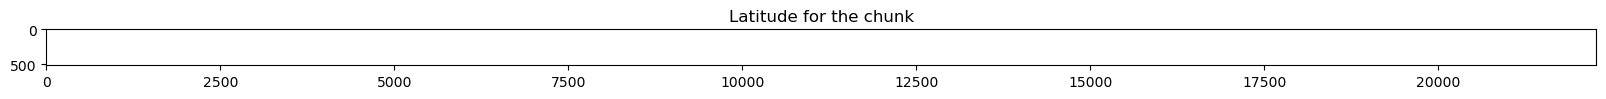

In [31]:
plot_data(chunk_lats[::-1],'Latitude for the chunk')

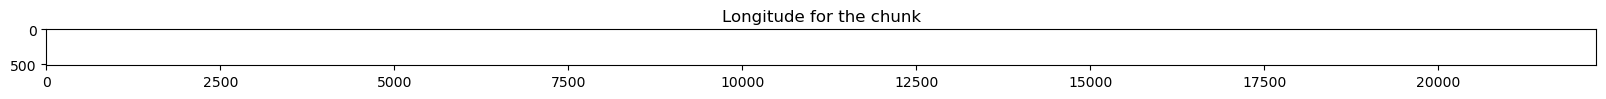

In [32]:
plot_data(chunk_lons[::-1],'Longitude for the chunk')

In [33]:
# determine the geolocation for the full disk grid for a specific SSD
rs,cs = np.indices((grid_parameters[ssd]['reference_grid_number_of_rows'],grid_parameters[ssd]['reference_grid_number_of_columns']))
lats,lons = grid_coordinates_to_geo_coordinates(rs,cs,grid_parameters,ssd)

KeyError: 0

In [ ]:
plot_data(lats[::-1],'Latitude for the full disk')